<img src="https://teaching.bowyer.io/SDSAI/0/img/IMPERIAL_logo_RGB_Blue_2024.svg" alt="Imperial Logo" width="500"/><br /><br />

Neural Networks and Deep Learning
==============
### SURG70098 - Surgical Data Science and AI
### Stuart Bowyer

## Intended Learning Outcomes
1.  Understand the concept behind neural networks and how they 'learn'
1.  Be able to build simple neural networks to address regression and classification problems
1.  Be aware of the limitations and challenges of neural networks and where to look to address them
1.  Have a preliminary understanding of what deep learning is and what it can be used for
1.  Be able to understand hyperparameter selection and optimisation


## MIMIC Dataset
The following code will load the datasets used in this lecture notes

In [71]:
%pip install pandas_gbq

import pandas as pd
import pandas_gbq

project_id = 'mimic-project-439314'  # @param {type:"string"}

df_day1_vitalsign = pandas_gbq.read_gbq("""
  SELECT
    *,
    (dod IS NOT NULL) AND (dod <= dischtime) AS mortality,
    weight / POWER(height/100, 2) > 30 AS obese
  FROM `physionet-data.mimiciv_derived.first_day_vitalsign`
  LEFT JOIN (
    SELECT
      subject_id,
      stay_id,
      gender,
      race,
      dischtime,
      admission_age,
      dod
    FROM
      `physionet-data.mimiciv_derived.icustay_detail`
  )
  USING(subject_id, stay_id)
  LEFT JOIN (
    SELECT
      stay_id,
      AVG(weight) as weight
    FROM
      `physionet-data.mimiciv_derived.weight_durations`
    GROUP BY
      stay_id
  )
  USING(stay_id)
  LEFT JOIN (
    SELECT
      stay_id,
      CAST(AVG(height) AS FLOAT64) AS height
    FROM
      `physionet-data.mimiciv_derived.height`
    GROUP BY
      stay_id
  )
  USING(stay_id)
  WHERE heart_rate_mean IS NOT NULL
""", project_id=project_id)

# Recap Supervised Learning
*   Last week, we studied a few methods for supervised learning, all of these have some limitations
    *   All methods involve some assumptions about model structure (e.g. linearity, mapped linearity)
    *   KNN and SVM do not scale well to very large data sets or high dimensionality
    *   Linear and logistic regression require feature engineering 
    *   Decision trees are prone to overfitting
    *   And more...

# Neural Networks
*   Neural networks are a machine learning method that aims to overcome these issues
*   Particularly with respect to:
    *   Large data
    *   High-dimensionality data
    *   Complex interdependent data
    *   (Unstructured data)

## Introduction to Neural Networks

### Bioinspiration
*   These models were created to mimic the function of biological neurons
*   By combining many neurons they are able to 
*   In reality, the aritifical neural networks are quite different from biological neural networks; however, they are very effective

### Artifical Neurons
Neural networks are made up from multiple artificial neurons

![Artificial neuron image](https://teaching.bowyer.io/SDSAI/5/img/Illustrations-SDSAI-05_Artifical-Neuron.svg)

### Activation Functions
*   Activation functions are a critical component of the neural network
*   They produce non-linearity
*   Therefore, allow it to model complex relationships
*   There are a range of functions

![Activation function illustration](https://teaching.bowyer.io/SDSAI/5/img/Illustrations-SDSAI-05_Activation-Functions.svg)

## Quick Exercise - Artificial Neuron Worked Example
For a three input neuron with the following input values and parameters, can you calculate (with simple Python) the output value of the neuron for the input `A Values` and the `B Values`?

You should get a separate output value for each input set

### Parameters
| Parameter | Value |
| --------- | ----- |
| weight 1  | 0.5   |
| weight 2  | 1.7   |
| weight 3  | 0.001 |
| bias      | -52   |
| Activation function | ReLU |

### Inputs
| Input     | A Values  | B Values  |
| --------- | --------- | --------- |
| input 1   | 65 kg     | 82 kg     |
| input 2   | 1.7 m     | 1.85 m    |
| input 3   | 8200 c/uL | 9800 c/uL |

### Possible Python Solution

In [16]:
w1 = 0.5
w2 = 1.7
w3 = 0.001
bias = -52

def relu(x):
    if (x < 0):
        return(0)
    return(x)

va1 = 65
va2 = 1.7
va3 = 8200

vb1 = 82
vb2 = 1.85
vb3 = 9800

output_a = relu(w1 * va1 + w2 * va2 + w3 * va3 + bias)
output_b = relu(w1 * vb1 + w2 * vb2 + w3 * vb3 + bias)

print(f'Neuron output for A is {output_a}')
print(f'Neuron output for B is {output_b}')


Neuron output for A is 0
Neuron output for B is 1.9450000000000074


### Neural Network
*   An assembly of artificial neurons in a network structure
*   Neurons are grouped into layers of three different types

![Simple artificial neural network](https://teaching.bowyer.io/SDSAI/5/img/Illustrations-SDSAI-05_ANN.svg)

### Why Neural Networks Work
*   Each individual neuron can model a simple activation function
*   By combining them in this structure, the combination of simple activation functions can model non-linear and complex relationships

| Training | Predicting |
| - | - |
| <img src="https://upload.wikimedia.org/wikipedia/commons/0/0c/Simplified_neural_network_training_example.svg" alt="Description of Image" style="width: 450px; display: block; margin: 0 auto;"> | <img src="https://upload.wikimedia.org/wikipedia/commons/b/b7/Simplified_neural_network_example.svg" alt="Description of Image" style="width: 450px; display: block; margin: 0 auto;"> |
| By <a href="//commons.wikimedia.org/wiki/File:Mikael_H%C3%A4ggstr%C3%B6m_at_pathology_in_2019_(crop).jpg" class="mw-file-description"></a><a href="//commons.wikimedia.org/wiki/User:Mikael_H%C3%A4ggstr%C3%B6m" title="User:Mikael Häggström">Mikael Häggström</a>, <a href="https://en.wikipedia.org/wiki/Medical_Doctor" class="extiw" title="en:Medical Doctor">M.D.</a> <a href="//commons.wikimedia.org/wiki/Mikael_H%C3%A4ggstr%C3%B6m" class="mw-redirect" title="Mikael Häggström">Author info</a>- <a href="//commons.wikimedia.org/wiki/User:Mikael_H%C3%A4ggstr%C3%B6m#Reusing_images" title="User:Mikael Häggström">Reusing images</a>- Conflicts of interest:&nbsp; None<a href="//commons.wikimedia.org/wiki/User:Mikael_H%C3%A4ggstr%C3%B6m" title="User:Mikael Häggström">Mikael Häggström</a>, <a href="https://en.wikipedia.org/wiki/Medical_Doctor" class="extiw" title="en:Medical Doctor">M.D.</a> - <span class="int-own-work" lang="en">Own work</span>, <a href="http://creativecommons.org/publicdomain/zero/1.0/deed.en" title="Creative Commons Zero, Public Domain Dedication">CC0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=138411803">Link</a> | By <a href="//commons.wikimedia.org/wiki/File:Mikael_H%C3%A4ggstr%C3%B6m_at_pathology_in_2019_(crop).jpg" class="mw-file-description"></a><a href="//commons.wikimedia.org/wiki/User:Mikael_H%C3%A4ggstr%C3%B6m" title="User:Mikael Häggström">Mikael Häggström</a>, <a href="https://en.wikipedia.org/wiki/Medical_Doctor" class="extiw" title="en:Medical Doctor">M.D.</a> <a href="//commons.wikimedia.org/wiki/Mikael_H%C3%A4ggstr%C3%B6m" class="mw-redirect" title="Mikael Häggström">Author info</a>- <a href="//commons.wikimedia.org/wiki/User:Mikael_H%C3%A4ggstr%C3%B6m#Reusing_images" title="User:Mikael Häggström">Reusing images</a>- Conflicts of interest:&nbsp; None<a href="//commons.wikimedia.org/wiki/User:Mikael_H%C3%A4ggstr%C3%B6m" title="User:Mikael Häggström">Mikael Häggström</a>, <a href="https://en.wikipedia.org/wiki/Medical_Doctor" class="extiw" title="en:Medical Doctor">M.D.</a> - <span class="int-own-work" lang="en">Own work</span>Reference: Ferrie, C., &amp; Kaiser, S. (2019) Neural Networks for Babies, Sourcebooks <span lang="en" dir="ltr"><a href="https://en.wikipedia.org/wiki/ISBN" class="extiw" title="en:ISBN"><span lang="en" dir="ltr">ISBN</span></a></span>: <a href="//commons.wikimedia.org/wiki/Special:BookSources/1492671207" title="Special:BookSources/1492671207">1492671207</a>., <a href="http://creativecommons.org/publicdomain/zero/1.0/deed.en" title="Creative Commons Zero, Public Domain Dedication">CC0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=137892223">Link</a> |

### Complex Neural Network Architecture
Networks with many neurons and many layers can model highly complex relationships

![Complex artificial neural network](https://teaching.bowyer.io/SDSAI/5/img/Illustrations-SDSAI-05_Complex-ANN.svg)

### Input Layer
*   **Function:** Takes the raw data and sends it into the network without any transformation or activation
*   **Number:** The number of neurons in the input layer is the number of features you have
*   **Connection:** Each input neuron is connected to each neuron in the first hidden layer
*   **Example:** Each input neuron would be one of the features you observed per patient

![Complex artificial neural network](https://teaching.bowyer.io/SDSAI/5/img/Illustrations-SDSAI-05_Complex-ANN.svg)

### Hidden Layer(s)
*   **Function:** Allow for the translation of the input data into increasingly abstract representations that model them
*   **Number of neurons:** The number of neurons per layer is a model parameter. More neurons can model more complex relationships.
*   **Number of layers:** The number of layers is a model parameter. More layers can model deeper level features.
*   **Connection:** Each neuron is (**typically**) connected to each neuron in the next layer
*   **Example:** The first layer could learn to derive BMI from height and weight

![Complex artificial neural network](https://teaching.bowyer.io/SDSAI/5/img/Illustrations-SDSAI-05_Complex-ANN.svg)

### Output Layer
*   **Function:** Takes the abstracted data representation from the final hidden layer and produces the final prediction/classification
*   **Number (regression):** A single output neuron combines the network data into a single value
*   **Number (binary classification):** A single output neuron with a value between 0 and 1
*   **Number (multi-classification):** One output neuron per output class
*   **Example:** For a mortality prediction the output layer would have one neuron that gives a probability of true/false

![Complex artificial neural network](https://teaching.bowyer.io/SDSAI/5/img/Illustrations-SDSAI-05_Complex-ANN.svg)

### Softmax
*   There is a challenge with multi-classification problems where you want to have a probability value per class ...
*   Consider a classifier with three possible outputs (high, medium, and low risk) and your output neurons produce `[2.2, 0.4, 0.1]`, but you want to know the probability of being in each risk category
*   Softmax is a function that allows you to combine your output layer values together and produce a probability distribution across the classes such that all sum to 1 (i.e. probabilities)
    *   e.g. `[2.2, 0.4, 0.1]` becomes `[0.78, 0.13, 0.10]`
*   This function is computationally efficient during training (which we will consider next)

### Summary
| **Aspect**                 | **Input Layer**                                    | **Hidden Layer(s)**                               | **Output Layer**                                  |
|----------------------------|----------------------------------------------------|---------------------------------------------------|---------------------------------------------------|
| **Role**                   | Receives and passes input data to the network      | Processes data, learns features and patterns      | Generates the final prediction or output          |
| **Data Handling**          | Takes raw input data (e.g., features, images)      | Transforms data through weighted connections      | Produces output suitable for the task (class/probability/value) |
| **Activation Function**    | None                                               | Non-linear functions (e.g., ReLU, Tanh, Sigmoid)  | Depends on the problem: Softmax, Sigmoid, Linear  |
| **Number of Neurons**      | Equal to the number of input features              | Varies based on network architecture              | Depends on the output type (e.g., 1 for regression, n for n-class classification) |
| **Complexity**             | Simple; no learning occurs in this layer           | Complex; learns hierarchical features and patterns| Simple; maps learned features to output space     |
| **Learning Role**          | No learning or transformations                     | Learns and extracts meaningful features           | Outputs the final result of the network’s learning|
| **Example**                | Each neuron represents a patient feature (e.g., age, heart rate, blood pressure) | Neurons learn interactions between features (e.g., BMI) | Outputs probability of mortality (e.g., risk score or binary prediction) |

## Training Neural Networks


### Network Initialisation
*   To start training a neural network on data, you need an initial 'guess' at the weights/biases
*   You can start by assigning the values randomly; however, the distribution for should be carefully considered to avoid training instability (see later on)
*   Methods such as Xavier (Glorot) or He (Kaiming) initialisation define distributions to sample from to for different activation functions

![Complex artificial neural network](https://teaching.bowyer.io/SDSAI/5/img/Illustrations-SDSAI-05_Training-ANN-2.svg)

### Forward Propagation
*   The next step is to simply use your (semi-randomly initialised) network to make a prediction for your training data
*   For example:
    *   we have a `2.1` and `1.0` as the two features of the first sample in our training data
    *   the neural network output predicts a probability of `0.8`
    *   however, the real value should be False (`0.0`)
    *   the model is currently poorly trained

![Artificial neural network training 3](https://teaching.bowyer.io/SDSAI/5/img/Illustrations-SDSAI-05_Training-ANN-3.svg)

### Loss Functions
*   To train the model, we need a 'loss function'
*   Simplistically, this is a measure of how 'bad' the model is at predicting
    *   i.e. a loss function of 0 would be correct
*   **Regression:** typically use the 'Mean Squared Error' (MSE)
*   **Classification:** typically uses the 'Cross-Entropy Loss'
*   There are others and you should explore these when you build a model - justify your choice

![Artificial neural network training 4](https://teaching.bowyer.io/SDSAI/5/img/Illustrations-SDSAI-05_Training-ANN-4.svg)

### How Do We Update the Model to Make it Better?
We want the cross-entropy loss to as low as possible, which means we want the output layer to predict the same as the training data ...

![Artificial neural network training 4](https://teaching.bowyer.io/SDSAI/5/img/Illustrations-SDSAI-05_Training-ANN-4.svg)

### Back Propagation - Conceptually
*   The idea is to 'nudge' the weights in the network so they slightly reduce the loss at each iteration
*   We step backwards through the neural network, at each layer:
    *   Adjust the weights and bias so that the output moves in the direction that minimises the loss
    *   Adjust the weights such that larger changes are applied to greater improvements
    *   Propogate the required changes (errors) in the previous layer's outputs
*   Once we reach the input layer, the neural network should be slightly better at the trained sample
*   Repeating this process over and over causes the network's parameters to converge on a trained configuration

![Artificial neural network training 4](https://teaching.bowyer.io/SDSAI/5/img/Illustrations-SDSAI-05_Training-ANN-4.svg)

### Back Propagation - Computationally
*   In practice, you want to minimise the loss for all your training samples at once
    *   So you combine them into a single loss (or cost) function
*   Python performs back propagation by computing the gradient of the cost function in the model parameters and adjusting them appropriately
*   How big a 'step' the solver takes at a time is controlled by the learning rate
*   This is a common computational approach called 'Gradient Descent'

<video width="640" height="360" controls loop autoplay muted>
  <source src="https://upload.wikimedia.org/wikipedia/commons/4/4c/Gradient_Descent_in_2D.webm" type="video/webm">
  Your browser does not support the video tag.
</video>

By Gpeyre, CC-SA 4.0 https://commons.wikimedia.org/wiki/File:Gradient_Descent_in_2D.webm

### Training Challenges
There are some challenges in training neural networks ...

*   **Vanishing Gradients:** learning can become very slow or stop in early layers due to the very shallow gradients of the sigmoid and tanh activation functions
*   **Exploding Gradients:** learning becomes unstable due to large gradients resulting from poor initialisation
*   **Dead ReLU Units:** learning stops because ReLU neurons get stuck in the 0 region with no gradient to recover

## Neural Network Classifier in `scikit-learn`
*   In `scikit-learn` the typical neural network is the `MLPClassifier`
*   This is a Multi-Layer Perceptron (a simple feedforward neural network)

In [ ]:
from sklearn.neural_network import MLPClassifier

## Exercise - Mortality Prediction
Take your mortality prediction models from last week's tutorial and try to use a neural network classifier, validate and compare your performance to the linear classifier.

Explore different model parameters:
*   What does increasing the number/size of layers achieve?
*   Which activation functions work?
*   What happens when you increase/decrease the learning rate?

What configuration gives you the best performance?

What do you think is limiting your ability to get better performance?

### Simple Solution

In [72]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler

# Prepare our data
data = df_day1_vitalsign.dropna(subset=['admission_age', 'heart_rate_mean', 'sbp_mean', 'glucose_mean', 'mortality'])
X = data[['admission_age', 'heart_rate_mean', 'sbp_mean', 'glucose_mean']]
Y = data['mortality']

# Create the Neural network with 20 neurons in the hidden layer
model = MLPClassifier(
    hidden_layer_sizes=(20),
    random_state=1
)

# Train Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

# Train the model
model.fit(X_train, Y_train)

# Test the model
Y_pred = model.predict(X_test)

# Metrics
print(f"Confusion Matrix:\n {confusion_matrix(Y_test, Y_pred)}")
print(f"Accuracy: {accuracy_score(Y_test, Y_pred)}")
print(f"f1-score: {f1_score(Y_test, Y_pred)}")
print(f"ROC AUC:  {roc_auc_score(Y_test, Y_pred)}")

# Cross validate to assess the balanced performance
nn_scores = cross_validate(model, X, Y, cv=5, scoring=['f1','accuracy','precision','recall','roc_auc'])

print(f'N:                              {len(Y)}')
print(f'Cross-Validation Accuracy Mean: {nn_scores["test_accuracy"].mean()}')
print(f'Cross-Validation F1 Mean:       {nn_scores["test_f1"].mean()}')
print(f'Cross-Validation ROC AUC Mean:  {nn_scores["test_roc_auc"].mean()}')

Confusion Matrix:
 [[12550    55]
 [ 1508   109]]
Accuracy: 0.890099845310083
f1-score: 0.12240314430095452
ROC AUC:  0.5315227169083349
N:                              71110
Cross-Validation Accuracy Mean: 0.8869076079313739
Cross-Validation F1 Mean:       0.10674687476466245
Cross-Validation ROC AUC Mean:  0.7005425104687292


# Deep Neural Networks
Deep neural networks are the most active area of ML research, here we will introduce the concept and give a few examples of approaches

## Introduction
*   Deep learning is the process of using neural networks to model highly complex relationships between data
*   Simplistically, these are neural networks with many hidden layers (maybe 10s or even 100s)
*   The idea is that more layers/neurons can abstract concepts to a much greater degree
*   Modelling these complex relationships requires **LARGE** datasets
*   Deep neural networks often involve more complicated neuron arrangements (e.g. RNN, CNN, etc.)

## Deep Neural Network Examples

### DenseNet-264
*   Convolutional Neural Network architecture
*   264 layers
*   33 million parameters

### AlphaFold from DeepMind (allegedly...)
*   Hybrid architecture
*   Dozens of layers
*   ~100 million parameters
*   Trained with ~1,000 TPUs for several months

### GPT-4 from OpenAI (allegedly...)
*   Transformer architecture
*   120 layers
*   1.8 trillion parameters
*   Trained with 1,000s of GPUs over 90-100 days (cost of $63M)

## Advantages
*   **High Performance:** these models are repeatedly shown to perform well on complex problems
*   **Model Abstraction/Translation:** the high degree of abstraction in hidden layers allows them to be applied/translated to related tasks
*   **Feature Engineering:** the model's ability to abstract the input data means it can find/engineer features itself
*   **Utilise Large and High-Dimensional Data:** the models are capable of learning detail from massive amounts of data with thousands of dimensions
*   **Flexibility:** the architecture can be configured to specialise on several types of data/problems

## Disadvantages
*   **Data Requirements:** massive datasets are required for training to learn complex relationships
*   **Computational Cost:** training can take a long time and require expensive resources
*   **High Parameterisation:** models have many parameters that need setting to perform optimally
*   **Overfitting:** massive numbers of parameters can end up overfitting the data
*   **Interpretability:** complex architectures and large numbers of parameters make the models almost impossible to interpret/explain

## Neural Networks for Computer Vision
*   Neural networks were crucial in the development of computer vision, e.g.:
    *   Image classification
    *   Object detection
    *   Image generation
    *   etc.
*   To train a neural network on 'unstructured' data such as a medical image you need to 'flatten' the data
*   Each pixel in the image becomes an individual feature, and is passed to the input layer of the neural network

![Image analysis NN](https://teaching.bowyer.io/SDSAI/5/img/Illustrations-SDSAI-05_Image-ANN.svg)

### Convolutional Neural Networks (CNN)
*   Special neurons are used in the convolution layers where a small filter is applied to the data
*   These filters identify (initially) simple elements of the image (e.g. edges)
*   By layering these filters, they can learn increasingly complex patterns (e.g. edges, windows, houses)
*   The structure of these filters are learnt during training

![Typical CNN](https://upload.wikimedia.org/wikipedia/commons/6/63/Typical_cnn.png)

By <a href="//commons.wikimedia.org/w/index.php?title=User:Aphex34&amp;action=edit&amp;redlink=1" class="new" title="User:Aphex34 (page does not exist)">Aphex34</a> - <span class="int-own-work" lang="en">Own work</span>, <a href="https://creativecommons.org/licenses/by-sa/4.0" title="Creative Commons Attribution-Share Alike 4.0">CC BY-SA 4.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=45679374">Link</a>

## Do you think these neural networks are capable of giving predictions that remember previous inputs?

For example, imagine you wanted to build a model to predict some adverse event during surgery, based on continuous monitoring data. You need your model to constantly be running on the latest observations

## Recurrent Neural Networks
*   So far, we have looked at 'feed forward' networks - i.e. the data is fed forward from the input to output layer
    *   These are 'stateless' - i.e. cannot remember anything between inputs
    *   It does not have to be this way
*   Recurrent Neural Networks (RNN) are neural networks with memory
    *   Long Short-Term Memory (LSTM) are the most popular RNN architecture that can 'remember' values over a long period and then 'forget' them when necessary

![Recurrent Neural Network](https://teaching.bowyer.io/SDSAI/5/img/Illustrations-SDSAI-05_RNN.svg)

*   RNNs were commonly used for timeseries data; however, have fallen out of fashion with the popularity of 'transformers'

## Transformers
*   Transformers do not worry about remembering the state between inputs - they take the whole history as an input each time
*   They have revolutionised NLP and other sequential (unstructured) data modelling tasks
*   **Key Components**
    *   **Self-attention:** allows the model to learn the importance of relationships between input tokens (i.e. surgery event -> infection event)
    *   **Positional encoding:** allows the model to understand the sequential order of inputs

# Model Reliability, Reproducibility, and Optimality

## In the last tutorial, what did you find with the SVM, KNN and decision tree methods when trying to get good performance?

## Hyperparameter Tuning
*   As models become more powerful, they tend to have increasing numbers of parameters
*   For example:
    *   Number of neighbours in KNN
    *   Depth of a decision tree
    *   Layers, neurons, activation functions, etc for neural networks
*   We call these **hyperparameters**
*   You have seen that variation in these parameters can effect model performance enormously

**How do you think we can ensure we have the best configuration for our model's hyperparameters?**

### Grid Search
Involves systematically searching combinations of hyperparameters to find the best score
*   Approach guarantees a 'reasonable' proximity to the optimal values
*   `from sklearn.model_selection import GridSearchCV`

![Grid search hyperparameter optimisation](https://upload.wikimedia.org/wikipedia/commons/b/b6/Hyperparameter_Optimization_using_Grid_Search.svg)

By <a href="//commons.wikimedia.org/w/index.php?title=User:Alexander_Elvers&amp;action=edit&amp;redlink=1" class="new" title="User:Alexander Elvers (page does not exist)">Alexander Elvers</a> - <span class="int-own-work" lang="en">Own work</span>, <a href="https://creativecommons.org/licenses/by-sa/4.0" title="Creative Commons Attribution-Share Alike 4.0">CC BY-SA 4.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=84255403">Link</a>

### Random Search
Involves randomly saerching combinations of hyperparameters to find the best score
*   Explores the continuous value space more efficiently than the grid search
*   `from sklearn.model_selection import RandomizedSearchCV`

![Random search hyperparameter optimisation](https://upload.wikimedia.org/wikipedia/commons/7/74/Hyperparameter_Optimization_using_Random_Search.svg)

By <a href="//commons.wikimedia.org/w/index.php?title=User:Alexander_Elvers&amp;action=edit&amp;redlink=1" class="new" title="User:Alexander Elvers (page does not exist)">Alexander Elvers</a> - <span class="int-own-work" lang="en">Own work</span>, <a href="https://creativecommons.org/licenses/by-sa/4.0" title="Creative Commons Attribution-Share Alike 4.0">CC BY-SA 4.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=84255404">Link</a>

### Bayesian Optimisation
Involves using an optimisation approach to search in areas where it expects the performance to be better
*   Typically finds optima more quickly than random search
*   `from skopt import BayesSearchCV`

![Bayesian Optimisation hyperparameter optimisation](https://upload.wikimedia.org/wikipedia/commons/3/3c/Hyperparameter_Optimization_using_Tree-Structured_Parzen_Estimators.svg)

By <a href="//commons.wikimedia.org/w/index.php?title=User:Alexander_Elvers&amp;action=edit&amp;redlink=1" class="new" title="User:Alexander Elvers (page does not exist)">Alexander Elvers</a> - <span class="int-own-work" lang="en">Own work</span>, <a href="https://creativecommons.org/licenses/by-sa/4.0" title="Creative Commons Attribution-Share Alike 4.0">CC BY-SA 4.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=84255405">Link</a>

#### Grid Search in `scikit-learn`

In [93]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

data = df_day1_vitalsign.dropna(subset=['admission_age', 'heart_rate_mean', 'sbp_mean', 'glucose_mean', 'mortality'])
X = data[['admission_age', 'heart_rate_mean', 'sbp_mean', 'glucose_mean']]
Y = data['mortality']

# Create the initial model
model = MLPClassifier(random_state=1)

# Define the grid search
grid_search = GridSearchCV(
    model,
    param_grid={
        'hidden_layer_sizes': range(5,45,5),
        'activation': ['relu', 'logistic', 'tanh']
    },
    scoring='roc_auc'
)

# Perform the grid search
grid_search.fit(X, Y)

# Get the best score and best parameters
print(f"Best Score:      {grid_search.best_score_}")
print(f"Best Parameters: {grid_search.best_params_}")

Best Score:      0.7274227972755576
Best Parameters: {'activation': 'logistic', 'hidden_layer_sizes': 40}


### Model Sensitivity/Stability
*   You can use the hyperparameter optimisation to assess the sensitivity and stability of a model
*   If small changes in parameters lead to large changes in performance, the model is 'sensitive' and maybe overfit
*   If large changes in parameters lead to small changes in performance, the model is either already at it's limit, underfit, or suffering from some other issues

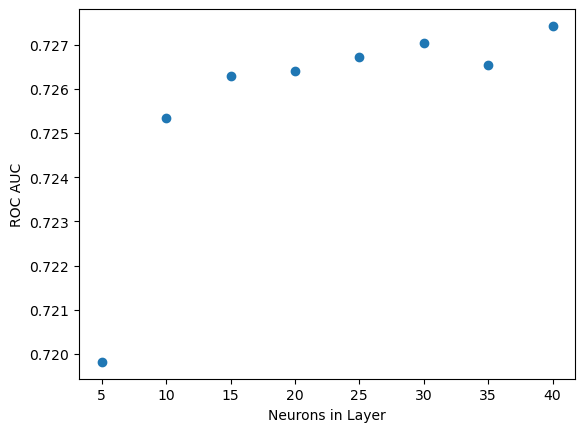

In [98]:
auc_values = grid_search.cv_results_['mean_test_score'][grid_search.cv_results_['param_activation'] == 'logistic']
nneuron_values = grid_search.cv_results_['param_hidden_layer_sizes'][grid_search.cv_results_['param_activation'] == 'logistic']

import matplotlib.pyplot as plt

plt.scatter(nneuron_values, auc_values)
plt.xlabel("Neurons in Layer")
plt.ylabel("ROC AUC")
plt.show()

# Wrap Up
*   You now have lots of tools to address supervised machine learning problems; however, experience and reading up on the nuances of each method is the difference between using them well
*   REMEMBER... if your model does not have the key features of the system/disease/procedure/etc. you are trying to predict, no matter how complex you make your model or how many samples you collect, it will never improve its performance

![](https://assets.cureus.com/uploads/figure/file/292667/article_river_6a398820513311ecb45235ba7f0fde7e-LRvsNN_plot4.png)

Issitt R W, Cortina-Borja M, Bryant W, et al. (February 21, 2022) Classification Performance of Neural Networks Versus Logistic Regression Models: Evidence From Healthcare Practice. Cureus 14(2): e22443. doi:10.7759/cureus.2244

## Before Next Session
*   Review background on neural networks
*   Complete the tutorial exercises

### New Material
*   Tutorial on CNN for image classification - https://www.tensorflow.org/tutorials/images/cnn
*   OPTIONAL Very detailed description of the DeepMind AlphaFold 3, so you can understand the complexity possible in Deep Neural Networks - https://elanapearl.github.io/blog/2024/the-illustrated-alphafold/

### Consolidation Reading
*   Excellent interactive Google tutorial that lets you visually explore neural networks - https://developers.google.com/machine-learning/crash-course/neural-networks 